# Работа на тему: <br>Мобильное динамическое распознавание изображений мультиязычных документов

Что нужно:
- Найти датасет (конфигурируется с помощью камеры)
- Посмотреть, как определять с помощью tesseract текст (детектить и обрезать) - отобразить
- Попробовать это улучшить
- Проблема с определением языка
- Проблема с "большими" документами
- Проблема определения языка в рамках одного документа
- Проблема смешанного текста на многих языках

Будущее:
- Попробовать закастомить tesseract
- Попробовать написать свой алгоритм для распознования текстов
- Усовершенствовать текущие существующие алгоритмы по валидации
- Перевести логику на другие языки программирования

Класс задач - компьютерное зрение. <br>
Пожелания: 
Разработка единого, кросс-платформенного решения на основе java с возможностью переноса на платформу ios, Android. 
Заказчик:
Своя тема
Итоговое тема: 
На согласовании.

Этап нулевой:
Установка. 
Для V8 не нужен gcc, используем легче решение: https://github.com/sqreen/PyMiniRacer
Непонятно, что с npm, но в текущей реализации можно опустить.
 
Этап первый: 
Распознанный текст с помощью tesseract и записать в документ HTML.

Сделать бета-версию на андроид. Подумать/посмотреть и, возможно, сделать все таки универсально - то есть для всего, куда можно засунуть keras.
-- Как выяснилось, почти везде есть V8 и eval() (даже в ios(!)) соответственно, цель изменяется - сделать общую скрипт-ориентированную логику для обработки данных с tesseract.
 
Этап второй: 
Создать логику по автоматическому определению языка.

Этап третий: 
Создать логику эволюции документа с довалидацией оригинала.

![alt text](test_multi2.png)

![alt text](img/IMG_2744.JPG)
![alt text](img/IMG_2747.JPG)

In [30]:
import PIL
import pytesseract
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import json
import math
import nltk
import random as r
from nltk.corpus import reuters
from collections import defaultdict
from py_mini_racer import py_mini_racer
from IPython.core.display import display, HTML, Markdown

def print_img (crimg):
    plt.imshow(crimg)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
RU_DF = pd.read_csv('lng/ru_gram.txt', delimiter='\t', names=['freq', 'word'])[1:1000]
EN_DF = pd.read_csv('lng/en_gram.txt', delimiter='\t', names=['word', 'freq'])[1:]

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
RU_DF['freq'] = pd.to_numeric(RU_DF['freq'], downcast='float')
RU_DF.head(10)

,freq,word
1.0,5190215.0,в
2.0,3164900.0,не
3.0,2729210.0,на
4.0,2064408.0,с
5.0,2064178.0,что
6.0,1146383.0,как
7.0,1092177.0,я
8.0,1046292.0,к
9.0,1040711.0,он
10.0,970931.0,по


In [32]:
EN_DF['freq'] = pd.to_numeric(EN_DF['freq'], downcast='float')
EN_DF.head(10)

,word,freq
1.0,of,33950064.0
2.0,and,29944184.0
3.0,to,25956096.0
4.0,in,17420636.0
5.0,i,11764797.0
6.0,that,11073318.0
7.0,was,10078245.0
8.0,his,8799755.0
9.0,he,8397205.0
10.0,it,8058110.0


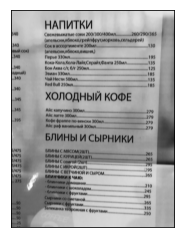

In [33]:
# img_cl = cv2.imread(r'test_real.jpg',0)
img_cl = cv2.imread(r'img/IMG_2744.JPG',0)
# img_cl = cv2.imread(r'test.png',0)
# img_cl = cv2.imread(r'test_multi2.png',0)
img = cv2.cvtColor(img_cl, cv2.COLOR_GRAY2RGB)
plt.imshow(img, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

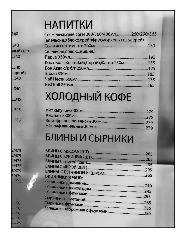

In [34]:
img_demoise = cv2.fastNlMeansDenoising(img,None,10,7,21)
print_img(img_demoise)

В некоторых случаях возможно уменьшение для ускорения распознования, но это приводит к потере данных:
```py
img_small = cv2.resize(img, (0,0), fx=0.95, fy=0.95)
print_img(img_small)
```

Если уменьшить размер в 2 раза, то он текста не видит.. <br>
<small>А что, если картинку разбивать на более малые части, их обрабатывать и потом выдавать результат...?</small>

### Попытки предобработки

In [35]:
def img_tresholding(img_path):
    imr_img = cv2.imread(img_path,0)
    img_b = cv2.medianBlur(imr_img,5)
    ret,th1 = cv2.threshold(img_b,127,255,cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(img_b,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    th3 = cv2.adaptiveThreshold(img_b,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

    titles = ['Original Image', 'Global Thresholding (v = 127)',
        'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    images = [img_b, th1, th2, th3]

    for i in range(4):
        plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
    imr_img = cv2.cvtColor(imr_img, cv2.COLOR_GRAY2RGB)
    b,g,r = cv2.split(imr_img)
    rgb_img = cv2.merge([r,g,b])
    gray = cv2.cvtColor(imr_img,cv2.COLOR_BGR2GRAY)
    # ниже переводиться картинка в threshold
    ret, thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    plt.subplot(121),plt.imshow(rgb_img)
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(thresh, 'gray')
    plt.title("Otus's binary threshold"), plt.xticks([]), plt.yticks([])
    plt.show()

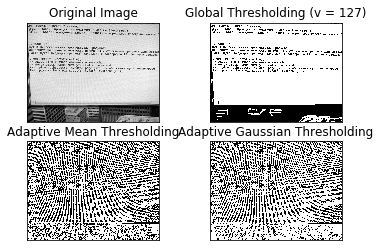

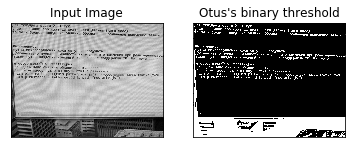

In [36]:
img_tresholding(r'img/test_multi.JPG')

Также были случаи, когда картинка преобразовывалась с ужасными шумами, которые перекрывали весь текст - фото с монитора (img/test_multi.JPG) - на картинке
Поэтому было принято решение временно отказаться от предобработки картинки, кроме перевода в ЧБ формат и удаление минимальных шумов с помощью CV2.

In [37]:
img = img_demoise

## Автоматическое определение языка

Идея заключается в том, чтобы, постепенно увеличивая видимую область изображения (crop) распознавать текст и определять его к какому либо языку. По скольку решения является легковесным (мобильным), то нужно производить поиск не по всему словарю, а по построенным биграммам на основе n наиболее частотных слов. Были взяты на текущий момент 2 языка - русский и английский.

Источники:
```py
ru_df = pd.read_csv('http://www.ruscorpora.ru/ngrams/1grams-3.zip', delimiter='\t', header=None, names=['freq', 'word']) 
ru_df.to_csv('ru_gram.txt', sep='\t', encoding='utf-8') 
en_df = (pd.read_html('https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/PG/2006/04/1-10000', header=0)[0].rename(columns={'Word': 'word', 'Count (per billion)': 'freq'})[['word', 'freq']])
en_df.to_csv('en_gram.txt', sep='\t', encoding='utf-8')
```

In [38]:
height, width, channels = img_demoise.shape
print ('Picture height: '+str(height)+'px\nwidth: '+str(width)+'px\nchannels: '+str(channels))

Picture height: 4032px
width: 3024px
channels: 3


In [39]:
def cropDetectLanguage(img, steps=30, validation=5, printer=0): # функция для большой картинки - определение всего
    # Определяем язык в steps шагов (с прерыванием validation, как только очевидно, что за язык)
    height, width, channels = img_demoise.shape
    step_h = math.trunc(height/steps)
    step_w = math.trunc(width/steps)
    crop_img = img
    ru_lm = trigram_lm(RU_DF)
    en_lm = trigram_lm(EN_DF)
    count = 1
    lang_arr = []
    lang = ''
    while(count <= steps):
        crop_img = img[0:(count*step_h), 0:(count*step_w)]
        if(printer==1):
            print_img(crop_img)
        lang_val = detectLanguage(crop_img, ru_lm, en_lm, 0.1, printer)
        if(lang_val!=''):
            lang_arr.append(lang_val)
        if(len(lang_arr)>(validation-1)):
            count = steps
        if(printer==1):
            print(lang_arr)
        count += 1
    rus_l = lang_arr.count('rus')
    eng_l = lang_arr.count('eng')
    if(rus_l>eng_l):
        lang = 'rus'
    elif(rus_l<eng_l):
        lang = 'eng'
    return lang

def detectLanguage(crop_img, ru_lm, en_lm, alpha=0.2, printer=0): # функция для маленькой картинки
    lang = ''
    # здесь перемножаем вероятности всех распознанных слов
    is_rus = detectLanguageRus(pytesseract.image_to_string(crop_img, lang="rus"), ru_lm, alpha, printer)
    is_en = detectLanguageEng(pytesseract.image_to_string(crop_img, lang="eng"), en_lm, alpha, printer)
    if(is_rus>is_en):
        lang = 'rus'
    elif(is_rus<is_en):
        lang = 'eng'
    return lang

def detectLanguageRus(text, ru_lm, alpha=0.2, printer=0):
    is_res = 0.0
    col_itd = singleImageTextValidate(text)
    # здесь довалидация полученного - склеивание, если символов меньше 4 со следующим
    if(printer==1):
        print('RU:')
        print(col_itd)
    is_rus = 0
    e = math.e
    for ir in range(len(col_itd)):
        if(len(col_itd[ir])>3):
            # is_rus *= abs(1 - pow(e,prob(col_itd[ir],ru_lm)))
            # exponential_moving_average - EMA
            is_rus = alpha * prob(col_itd[ir],ru_lm) + (1 - alpha) * is_rus
    if(printer==1):
        print('RU:'+str(is_rus))
    if (is_rus!=0):
        is_res = is_rus
    return is_res

def detectLanguageEng(text, en_lm, alpha=0.2, printer=0):
    is_res = 0.0
    col_itd = singleImageTextValidate(text)
    if(printer==1):
        print('EN:')
        print(col_itd)
    is_eng = 0
    e = math.e
    for ir in range(len(col_itd)):
        if(len(col_itd[ir])>3):
            # is_eng *= abs(1 - pow(e,prob(col_itd[ir],en_lm)))
            # exponential_moving_average - EMA
            is_eng = alpha * prob(col_itd[ir],en_lm) + (1 - alpha) * is_eng
    if(printer==1):
        print('EN:'+str(is_eng))
    if (is_eng!=0):
        is_res = is_eng
    return is_res

def singleImageTextValidate(text,mod='array'):
    result = text
    text_arr = clean(text).split('\n')
    if(len(text_arr)>1):
        n = 0
        while n < len(text_arr):
            if(text_arr[n]!=None and len(text_arr[n])<4):
                range_n = len(text_arr)
                if((n + 1)<len(text_arr)):
                    text_arr[n] += text_arr[n + 1]
                    text_arr[n + 1] = None;
            n += 1
    text_arr = list(filter(None, text_arr))
    if(mod=='string'):
        # Здесь в будующем доделать склейку еще и по параметрам
        # result = ''.join([str(x) for x in text_arr])
        result = re.sub('[^А-Яа-я0-9A-Za-z\s\W]', '', text, re.UNICODE)
    else:
        result = text_arr
    return result

def clean(s):
    s = re.sub('[^А-Яа-я0-9A-Za-z]', '\n', s, re.UNICODE)
    return s
    
    
def trigram_lm(df):
    model = defaultdict(lambda: defaultdict(lambda: 0))

    # counts
    for _, row in df.iterrows():
        for w1, w2, w3 in nltk.ngrams(row['word'], 3, pad_right=True, pad_left=True):
            model[(w1, w2)][w3] += row['freq']

    # probs
    for w1_w2 in model:
        total_count = float(sum(model[w1_w2].values()))
        for w3 in model[w1_w2]:
            model[w1_w2][w3] /= total_count

    return model

def prob(str, model, c=10**-10):
    res = 1
    for w1, w2, w3 in nltk.ngrams(str, 3, pad_right=True, pad_left=True):
        res *= model[w1, w2][w3] + c
    return math.pow(res, 1/len(str))

In [40]:
%%time
DOCUMENT_LANGUAGE = cropDetectLanguage(img,10,3,0)
print(DOCUMENT_LANGUAGE)

rus
CPU times: user 1.38 s, sys: 94.3 ms, total: 1.48 s
Wall time: 6.17 s


Здесь входной функцией для запуска всей логики является
```py
def cropDetectLanguage(img, steps=30, validation=5, printer=0):
```
Функция определения языка в _steps_ шагов (с прерыванием _validation_, как только очевидно, что за язык).<br>
Параметр _validation_ необходимо ставить **нечетным** .<br>
Последним параметром функции является флаг отображения процесса распознования.

Данная функция работает в большинстве случаев, если передаваемый на картинке текст достаточно большой.

In [41]:
%%time
print("Image size: "+str(img.size))
print("Text size: "+str(len(pytesseract.image_to_string(img, lang=DOCUMENT_LANGUAGE))))

Image size: 36578304
Text size: 1140
CPU times: user 1.32 s, sys: 40 ms, total: 1.36 s
Wall time: 3.96 s


In [42]:
%%time
print(pytesseract.image_to_data(img, lang=DOCUMENT_LANGUAGE))

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	3024	4032	-1	
2	1	1	0	0	0	630	208	866	165	-1	
3	1	1	1	0	0	630	208	866	165	-1	
4	1	1	1	1	0	630	208	866	165	-1	
5	1	1	1	1	1	630	208	866	165	86	НАПИТКИ
2	1	2	0	0	0	0	362	3024	2114	-1	
3	1	2	1	0	0	0	362	3024	259	-1	
4	1	2	1	1	0	0	362	3024	231	-1	
5	1	2	1	1	1	0	428	131	63	62	.340
5	1	2	1	1	2	617	439	552	66	87	Свежевыжатые
5	1	2	1	1	3	1191	451	166	48	90	соки
5	1	2	1	1	4	1380	431	548	68	89	200/300/400мл
5	1	2	1	1	5	1934	480	283	16	91	................
5	1	2	1	1	6	2220	427	462	71	88	260/290/365
5	1	2	1	1	7	2778	362	40	179	67	,
5	1	2	1	1	8	2994	374	30	219	59	‹
4	1	2	1	2	0	622	536	1824	85	-1	
5	1	2	1	2	1	622	536	1824	85	61	(апельсин‚яблоко‚грейпфрупморкоВцсельдерей)
3	1	2	2	0	0	0	639	2656	88	-1	
4	1	2	2	1	0	0	639	2656	88	-1	
5	1	2	2	1	1	0	639	146	62	54	„340
5	1	2	2	1	2	622	650	130	64	87	Сок
5	1	2	2	1	3	773	665	37	48	88	в
5	1	2	2	1	4	829	660	501	67	89	ассортименте
5	1	2	2	1	5	1350	646	221	63	91	200мл

In [43]:
# Здесь доработать функцию, которая будет искать слова по словарю определенного языка и валидировать их
def imageToObject(input_img, lang, ru_lm, en_lm, printer=0):
    json_obj = []
    itd_str = ''
    if (lang!=''):
        itd_str = pytesseract.image_to_data(input_img, lang=lang)
    else:
        itd_str = pytesseract.image_to_data(input_img)
    rows_strs = itd_str.split('\n')
    headers = rows_strs[0].split('\t') 
    rows = rows_strs[1:]
    for i in range(len(rows)):
        cur_obj = {}
        cols = rows[i].split('\t')
        need_translate = ''
        for h in range(len(headers)):
            if(h < len(cols)):
                if(headers[h]=="text" and len(cols[h])>3):
                    # здесь определяем язык слова и его необходимость изменения
                    need_translate = wordInDocLanguage(cols[h],lang, ru_lm, en_lm, printer)
                    if(need_translate==lang):
                        need_translate = ''
                cur_obj[headers[h]] = cols[h]
            else:
                cur_obj[headers[h]] = ''
        # Валидируем текст на картинке
        if(need_translate!=''):
            json_obj.append(wordAutoLanguage(cur_obj,input_img, lang, ru_lm, en_lm, printer))
        else:
            json_obj.append(cur_obj)
    json_norm = to_rows_normalization(json_obj,0.4,printer)
    json_norm_n = rows_sort_and_validate(json_norm)
    return json_norm_n

def wordInDocLanguage(word,lang,ru_lm,en_lm, printer):
    # Функция, которая говорит о необходимости переопределить текст
    good_lang = '';
    if(lang=='rus'):
        is_rus = detectLanguageRus(word,ru_lm,0.2,printer)
        if(is_rus<0.0001):
            good_lang = 'eng'
    if(lang=='eng'):
        is_eng = detectLanguageEng(word,en_lm,0.2,printer)
        if(is_eng<0.0001):
            good_lang = 'rus'
    return good_lang;

def wordAutoLanguage(obj, img, docLang, ru_lm, en_lm, printer):
    if (len(re.sub('[^А-Яа-я0-9A-Za-z]', '', obj["text"]))>0):
        if(printer==1):
            print('------------------')
        to = int(obj["top"])#-2#-math.trunc(int(obj["height"])/3)

        ho = int(obj["height"])#+4#+math.trunc(int(obj["height"])*2/3)
        if(to>2):
            to -= 2
            ho += 4
        lo = int(obj["left"])#-2#-math.trunc(int(obj["width"])/3)
        wo = int(obj["width"])#+4#+math.trunc(int(obj["width"])*2/3)
        if(lo>2):
            lo -= 2
            wo += 4
        crop_img = img[to:(to+ho), lo:(lo+wo)] # обрезаем
        lang_val = detectLanguage(crop_img, ru_lm, en_lm, 0.5, printer) # пытаемся определить язык
        if(printer==1):
            print_img(crop_img)
            print('   old:'+obj["text"])
            print('   detected lang:'+lang_val)
        if(lang_val!=''): # если язык определели
            obj["text"] = singleImageTextValidate(pytesseract.image_to_string(crop_img, lang=lang_val),'string')
            if(printer==1):
                print('   new:'+obj["text"])
        if(printer==1):
            print('------------------')
    return obj

# Функция, которая пробегается по всем словам, смотрит их расположение и записывать в одну строку
# условием является то, что, если 2 элемента перекрываются более, чем на заданный процент (от меньшего элемента)

# Минусом является то, что если текст маленький, но немного удален - мы его не детектим
# Нужно вычислять "расстояние" между текстом
# То же самое, если текст очень большой, то он начинает все объединяться со многими другими - это некорректно
# Нужно придумать метрику, основанную на корреляции высоты и близости векторов - допустимые размеры склеивания
# Пока можно понимать на сколько одно перекрывает другое и если это больше 40%, то объединять
def to_rows_normalization(obj, top_diff = 0.4, printer=0):
    # top_diff - описывает какой процент перекрытия по высоте от меньшего нужно,
    # чтобы элементы схлопнулись в строчку
    norm_obj = []
    # предположим, что первый элемент - первая строка
    first = {}
    objs_len = len(obj)
    ind = 0
    while ind < objs_len:
        if (len(re.sub('[^А-Яа-я0-9A-Za-z]', '', obj[ind]["text"]))>0):
            first = obj[ind]
            ind = objs_len
        ind = ind + 1
    norm_obj.append({"elems":[],"height":"0","top":"0", "left":"0"})
    for i in range(objs_len): 
        if(printer==1):
            print(str(i)+' of '+str(len(obj))+' total rows: '+str(len(norm_obj)))
        t2 = int(obj[i]["top"])
        h2 = int(obj[i]["height"])
        w2 = int(obj[i]["width"])
        if(printer==1):
            print(obj[i]["height"]+':'+str(t2))
        if (h2>0 and w2>0 and len(re.sub('[^А-Яа-я0-9A-Za-z]', '', obj[i]["text"]))>0):
            j = 0
            new_flg = 1
            while j < len(norm_obj):
                t1 = int(norm_obj[j]["top"])
                h1 = int(norm_obj[j]["height"])
                add_flg = 0
                
                # История про перекрытия
                if(printer==1):
                    print('-   '+str(t1)+' < '+str(t2+h2)+' && '+str(t1+h1)+' > '+str(t2+h2))
                    print('--   '+str(t2)+' < '+str(t1+h1)+' && '+str(t2+h2)+' > '+str(t1+h1))
                if (t1<t2+h2 and t1+h1>=t2+h2):
                    add_flg = 1
                elif (t2<t1+h1 and t2+h2>=t1+h1):
                    add_flg = 1
                if (add_flg==1):
                    minim_h = h2
                    if(h1<h2): 
                        minim_h = h1
                    diff_sq = 0
                    if ((t1+h1)>(t2+h2)):
                        diff_sq = h1 - (t1+h1-t2-h2)
                    else:
                        diff_sq = h2 - (t2+h2-t1-h1)
                    percent_diff = abs(diff_sq/minim_h);
                    if(printer==1):
                        print(percent_diff)
                    
                    if (percent_diff>top_diff):
                        # Добавить - если перекрывает больше, чем на 40% (top_diff) меньшего, то добавляем
                        norm_obj[j]["elems"].append(obj[i])
                        if(printer==1):
                            print(norm_obj[j]["elems"])
                        new_flg = 0
                        if(h2>h1):
                            norm_obj[j]["height"] = str(h2)
                        j = len(norm_obj)
                        
                # История про близость строки и нового 
                # Для учета сильно разряженных документов
                # Реализация на текущий момент отложена
                
                j = j+1
            if (new_flg==1):
                norm_obj.append({"elems":[obj[i]],"height":obj[i]["height"],"top":obj[i]["top"], "left":obj[i]["left"]})
                if(printer==1):
                    print('   new row: '+obj[i]['text'])
    return norm_obj

# Нужна еще функция, которая будет приводить строки в нормальный вид - вычислять по среднему размер тескта, отступы
# Плюс сортировку сторк по top - для человеческого рендеринга
# Дополнительно - доопределение слов из текста (если выйдет)
def rows_sort_and_validate(rows):
    grows = []
    len_doc = len(rows)
    ri = 1
    grows.append(rows[0]);
    while ri<len_doc:
        # если top больше текущего последнего в массиве, то append
        # в противном случае prepend
        # array = np.insert(array, 0, value, axis=0) - prepend
        grs_l = len(grows)
        if(int(rows[ri]['top'])>int(grows[grs_l-1]['top'])):
            grows.append(rows[ri])
        elif(int(rows[ri]['top'])<int(grows[0]['top'])):
            grows = np.insert(grows, 0, rows[ri])
        else:
            gi = 0
            while (gi<grs_l):
                lgi = 0
                if(gi+1<grs_l): 
                    lgi = gi+1
                else : 
                    lgi = gi
                t0 = int(grows[gi]['top']);
                t1 = int(grows[lgi]['top']);
                ti = int(rows[ri]['top']);
                if(ti<t0 and ti>t1):
                    # ti appned after t0
                    grows = np.insert(grows, (gi+1), rows[ri])
                gi = gi + 1
        ri = ri + 1
        
        #Здесь же сделать историю по валидации (сортировки) слов в строке
        
    return grows

Ниже мы преобразуем текст в объект, который возможно, в свою очередь, преобразовать в удобный формат JSON. 

In [44]:
%%time
ru_lm = trigram_lm(RU_DF)
en_lm = trigram_lm(EN_DF)
json_py_obj = imageToObject(img, DOCUMENT_LANGUAGE, ru_lm, en_lm,0)
json_py_str = json.dumps(json_py_obj)
print(len(json_py_str))

16217
CPU times: user 3.33 s, sys: 826 ms, total: 4.16 s
Wall time: 42.1 s


На текущий момент скорость распознования первого, основного документа, в среднем занимает около 30-40 секунд, что достаточно много, но есть возможность оптимизации алгоритма и перехода на более быстрые языки, создание библиотеки.

Распознование работает корректно. <br>
Далее создадим функцию для записи файла, генерации 2ух видов документов.

## Отображение (frontend)

In [63]:
def docConfiger(json_py_str,mode='html',save='save',display_mode='display'):
    ctx = py_mini_racer.MiniRacer()
    js_str = getJSFunc()
    ctx.eval(js_str)
    if(mode=='html'):
        result_doc = ctx.call("start",json_py_str)
        if(save=='save'):
            saveToFile(result_doc,mode)
        if(display_mode=='display'):
            html_str = getHTMLStr(result_doc)
            display(HTML(html_str))
        else:
            print(result_doc)
    elif(mode=='md'):
        result_docMD = ctx.call("start",json_py_str,'MD')
        if(save=='save'):
            saveToFile(result_docMD,mode)
        if(display_mode=='display'):
             display(Markdown(result_docMD))
        else:
            print(result_docMD)

def saveToFile(result_doc,mode='html'):
    file_name = "Output_"+generate_uuid()
    if(mode=='html'):
        text_file = open(file_name+".html", "w")
        text_file.write(result_doc)
        text_file.close()
    elif(mode=='md'):
        text_file = open(file_name+".md", "w")
        text_file.write(result_doc)
        text_file.close()

def generate_uuid():
    random_string = ''
    random_str_seq = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
    uuid_format = [2, 4]
    for n in uuid_format:
        for i in range(0,n):
            random_string += str(random_str_seq[r.randint(0, len(random_str_seq) - 1)])
        if n != 12:
            random_string += '_'
    return random_string

def getHTMLStr(result_doc):
    return """<iframe id="FileFrame" src="about:blank" width="800" height="400"></iframe>
<script type="text/javascript">
    var doc = document.getElementById(\'FileFrame\').contentWindow.document;
    doc.open();
    doc.write(" """+ result_doc.replace("\"",'\\"')+""" ");
    doc.close();
</script>
"""
        
def getJSFunc():
    return """
function start(JSONstr,type) {
    var doc = new json_to_html();
    doc._init(JSONstr);
    var result = '';
    switch(type) {
        case 'HTML':
            result = doc.toHtml();
        break;
        case 'MD':
            result = doc.toMarkdown();
        break;
        default:
            result = doc.toHtml();
        break;
    }
    return result;
};
function json_to_html(json) {
    this._obj = null;
    this._init = function(json_str) {
        this._obj = JSON.parse(json_str);
    }
    this.toHtml = function() {
        var cur = this._obj;
        var res_str = '<html><head></head><body style="background:#e0e0e0;">';
        for(var i = 0;i<cur.length;i++) {
            res_str += '<div style="background:#FFF;'+
            'top:'+cur[i].top+'px;'+
            'height:'+cur[i].height+'px;'+
            'padding-left:'+cur[i].left+'px;">';
            var prev_left = parseInt(cur[i].left);
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                res_str += '<span style="margin-left:'+
                (cur[i].elems[ie].left - prev_left)+'px;'+
                'width:'+cur[i].elems[ie].width+'px;'+
                'height:'+cur[i].elems[ie].height+'px;font-size:'+cur[i].elems[ie].height+'px;">'+
                //здесь пока поставлен font-size на конкретный элемент - в будующем - на всю строку
                cur[i].elems[ie].text+'</span>';
                prev_left = parseInt(cur[i].elems[ie].width)+parseInt(cur[i].elems[ie].left);
            }
            res_str += '</div>';
        }
        res_str += '</body></html>';
        return res_str;
    }
    this.toMarkdown = function() {
        var cur = this._obj;
        var res_str = '';
        var docHeight = 0;
        var docWidth = 0;
        var maxRowHeight = 0;
        for(var hi = 0;hi<cur.length;hi++) {
            if(maxRowHeight<parseInt(cur[hi].height)) {
                maxRowHeight = parseInt(cur[hi].height);
            }
            for (var ie = 0;ie < cur[hi].elems.length;ie++) {
                var el_w = parseInt(cur[hi].elems[ie].width)+parseInt(cur[hi].elems[ie].left);
                if(docWidth < el_w) {
                    docWidth = el_w;
                }
            }
            docHeight += parseInt(cur[hi].height);
        }
        docHeight = maxRowHeight+(0.001*docHeight);
        // res_str += docHeight;
        for(var i = 0;i<cur.length;i++) {
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                var typeAdd = 0;
                var c_perc = Math.round((cur[i].elems[ie].height/docHeight)*100);
                if(c_perc>98) {
                    typeAdd = 1;
                } else if(c_perc<98&&c_perc>96) {
                    typeAdd = 2;
                } else if(c_perc<96&&c_perc>93) {
                    typeAdd = 3;
                } else if(c_perc<93&&c_perc>89) {
                    typeAdd = 4;
                } else if(c_perc<89&&c_perc>84) {
                    typeAdd = 5;
                } else if(c_perc<84&&c_perc>78) {
                    typeAdd = 6;
                } else if(c_perc<8) {
                    typeAdd = 7;
                }
                //&nbsp;
                var nbsp_prc = 0;
                var nbsp_str = '';
                if(ie>0&&ie<cur[i].elems.length) {
                    nbsp_prc = Math.round(((cur[i].elems[ie].left - (cur[i].elems[ie-1].left+cur[i].elems[ie-1].width))/docWidth)*100);
                } else if(ie==0) {
                    nbsp_prc = Math.round((cur[i].elems[ie].left/docWidth)*100);
                }
                for(var ni = 0;ni < nbsp_prc; ni++) {
                    nbsp_str += '&nbsp;';
                }
                switch(typeAdd){
                    case 1:
                        res_str += '<h1>'+nbsp_str+cur[i].elems[ie].text+'</h1>';
                        break;
                    case 2:
                        res_str += '<h2>'+nbsp_str+cur[i].elems[ie].text+'</h2>';
                        break;
                    case 3:
                        res_str += '<h3>'+nbsp_str+cur[i].elems[ie].text+'</h3>';
                        break;
                    case 4:
                        res_str += nbsp_str+' **_'+cur[i].elems[ie].text+'_**';
                        break;
                    case 5:
                        res_str += nbsp_str+' **' +cur[i].elems[ie].text+'** ';
                        break;
                    case 6:
                        res_str += nbsp_str+' _'+cur[i].elems[ie].text+'_ ';
                        break;
                    case 7:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height*2);
                        var ns_str = '';
                        while(ns--) { ns_str += '&nbsp;'; }
                        res_str += nbsp_str+'<small>'+cur[i].elems[ie].text+ns_str+'</small>';
                        break;
                    default:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height*2);
                        var ns_str = '';
                        while(ns--) { ns_str += '&nbsp;'; }
                        res_str += nbsp_str+cur[i].elems[ie].text+ns_str;
                        break;
                }
                //res_str += c_perc;
            }
            res_str += '<br>';
        }
        return res_str;
    }
};
"""


Обработка и генерация документа происходит в JS (эмулируя какую-либо платформу/браузер - используем движок V8 от mozilla)

https://github.com/sqreen/PyMiniRacer

Выбор обусловлен тем, что возможность запуска JS возможно в различных сред (java Nashorn, Браузеры и тд)

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;НАПИТКИ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>.340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;CaemesblmaTble&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;СОКИ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;200/300/400мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;260/ 290/365&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(апельсин,яблоко‚грейпфрут,морковь‚сельдерей)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>„340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Сок&nbsp;&nbsp;&nbsp;&nbsp;в&nbsp;&nbsp;accopmme HTe&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;200мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;130&nbsp;&nbsp;&nbsp;&nbsp;<br>эвый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;СОК)&nbsp;&nbsp;&nbsp;&nbsp;(апельсин,яблоко‚вишня‚)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>„340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hepbe&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ЗЗОмл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;195&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кока—Кола‚Кола-Лайт‚Спрайт,Фа нта&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;250мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;35&nbsp;&nbsp;&nbsp;<br>…340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Бон&nbsp;&nbsp;&nbsp;&nbsp;Аква&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;С/г,&nbsp;&nbsp;б/г&nbsp;&nbsp;&nbsp;оооооооооооооо&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;125&nbsp;&nbsp;&nbsp;&nbsp;<br>падный)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Baman&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ЗЗОмл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;185&nbsp;&nbsp;&nbsp;&nbsp;<br>„340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Чай&nbsp;&nbsp;&nbsp;&nbsp;Нести&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;500мп&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;135&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Веб&nbsp;&nbsp;&nbsp;&nbsp;Bull&nbsp;&nbsp;&nbsp;&nbsp;250мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;185&nbsp;&nbsp;&nbsp;&nbsp;<br>‚...340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br><h1>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;холодный</h1> _КОФЕ_ <br>...345&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;капучино&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ЗООмл..&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2&nbsp;79&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;латте&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;300мл..&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;279&nbsp;&nbsp;&nbsp;&nbsp;<br>.…395&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кофе&nbsp;&nbsp;&nbsp;&nbsp;c|>panne&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;по—венски&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;300мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;......ОСООООООООО .....&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;79&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;раф&nbsp;&nbsp;&nbsp;ванильный&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;БЛИНЫ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;И&nbsp;&nbsp; **СЫРНИКИ** <br>

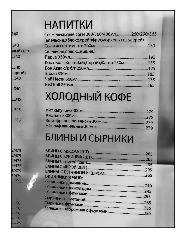

In [46]:
docConfiger(json_py_str,'html','save','display')
docConfiger(json_py_str,'md','','display')
print_img(img)

Как видно, из фотографии и полученных документов - распознование и доперевод происходит достаточно точно.

Код Javascript
```javascript
function start(JSONstr,type) {
    var doc = new json_to_html();
    doc._init(JSONstr);
    var result = '';
    switch(type) {
        case 'HTML':
            result = doc.toHtml();
        break;
        case 'MD':
            result = doc.toMarkdown();
        break;
        default:
            result = doc.toHtml();
        break;
    }
    return result;
};
function json_to_html(json) {
    this._obj = null;
    this._init = function(json_str) {
        this._obj = JSON.parse(json_str);
    }
    this.toHtml = function() {
        var cur = this._obj;
        var res_str = '<html><head></head><body style="background:#e0e0e0;">';
        for(var i = 0;i<cur.length;i++) {
            res_str += '<div style="background:#FFF;'+
            'top:'+cur[i].top+'px;'+
            'height:'+cur[i].height+'px;'+
            'padding-left:'+cur[i].left+'px;">';
            var prev_left = parseInt(cur[i].left);
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                res_str += '<span style="padding-left:'+
                (cur[i].elems[ie].left - prev_left)+'px;'+
                'width:'+cur[i].elems[ie].width+'px;'+
                'height:'+cur[i].elems[ie].height+'px;font-size:'+cur[i].elems[ie].height+'px;">'+
                //здесь пока поставлен font-size на конкретный элемент - в будующем - на всю строку
                cur[i].elems[ie].text+'</span>';
                prev_left = parseInt(cur[i].elems[ie].width)+parseInt(cur[i].elems[ie].left);
            }
            res_str += '</div>';
        }
        res_str += '</body></html>';
        return res_str;
    }
    this.toMarkdown = function() {
        var cur = this._obj;
        var res_str = '';
        var docHeight = 0;
        var docWidth = 0;
        var maxRowHeight = 0;
        for(var hi = 0;hi<cur.length;hi++) {
            if(maxRowHeight<parseInt(cur[hi].height)) {
                maxRowHeight = parseInt(cur[hi].height);
            }
            for (var ie = 0;ie < cur[hi].elems.length;ie++) {
                var el_w = parseInt(cur[hi].elems[ie].width)+parseInt(cur[hi].elems[ie].left);
                if(docWidth < el_w) {
                    docWidth = el_w;
                }
            }
            docHeight += parseInt(cur[hi].height);
        }
        docHeight = maxRowHeight+(0.001*docHeight);
        // res_str += docHeight;
        for(var i = 0;i<cur.length;i++) {
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                var typeAdd = 0;
                var c_perc = Math.round((cur[i].elems[ie].height/docHeight)*100);
                if(c_perc>98) {
                    typeAdd = 1;
                } else if(c_perc<98&&c_perc>96) {
                    typeAdd = 2;
                } else if(c_perc<96&&c_perc>93) {
                    typeAdd = 3;
                } else if(c_perc<93&&c_perc>89) {
                    typeAdd = 4;
                } else if(c_perc<89&&c_perc>84) {
                    typeAdd = 5;
                } else if(c_perc<84&&c_perc>78) {
                    typeAdd = 6;
                } else if(c_perc<8) {
                    typeAdd = 7;
                }
                //&nbsp;
                var nbsp_prc = 0;
                var nbsp_str = '';
                if(ie>0&&ie<cur[i].elems.length) {
                    nbsp_prc = Math.round(((cur[i].elems[ie].left - (cur[i].elems[ie-1].left+cur[i].elems[ie-1].width))/docWidth)*100);
                } else if(ie==0) {
                    nbsp_prc = Math.round((cur[i].elems[ie].left/docWidth)*100);
                }
                for(var ni = 0;ni < nbsp_prc; ni++) {
                    nbsp_str += '&nbsp;';
                }
                switch(typeAdd){
                    case 1:
                        res_str += '<h1>'+nbsp_str+cur[i].elems[ie].text+'</h1>';
                        break;
                    case 2:
                        res_str += '<h2>'+nbsp_str+cur[i].elems[ie].text+'</h2>';
                        break;
                    case 3:
                        res_str += '<h3>'+nbsp_str+cur[i].elems[ie].text+'</h3>';
                        break;
                    case 4:
                        res_str += nbsp_str+' **_'+cur[i].elems[ie].text+'_**';
                        break;
                    case 5:
                        res_str += nbsp_str+' **' +cur[i].elems[ie].text+'** ';
                        break;
                    case 6:
                        res_str += nbsp_str+' _'+cur[i].elems[ie].text+'_ ';
                        break;
                    case 7:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height*2);
                        var ns_str = '';
                        while(ns--) { ns_str += '&nbsp;'; }
                        res_str += nbsp_str+'<small>'+cur[i].elems[ie].text+ns_str+'</small>';
                        break;
                    default:
                        var ns = Math.round(cur[i].elems[ie].width/cur[i].elems[ie].height*2);
                        var ns_str = '';
                        while(ns--) { ns_str += '&nbsp;'; }
                        res_str += nbsp_str+cur[i].elems[ie].text+ns_str;
                        break;
                }
                //res_str += c_perc;
            }
            res_str += '<br>';
        }
        return res_str;
    }
};
```

> Перевод данных в документ происходит относительно точно. Для реального использования также необходима доработка алгоритмов (например, применение нормального распределения для определения шрифта).

> Примеры отображения разметки для генерируемых документов:

# 1
## 2
### 3
**_4_**<br>
**5**<br>
_6_<br>
<small>7</small><br>
<span>default</span><br>

> Дальше проблема заключается в том, что нужно отслеживать состояние документа и сравнивать старое и новое. 

## Эволюция документа

In [47]:
def levenshtein(a, b): # Расстояние Ливенштейна
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current_row = range(n+1)
    for i in range(1, m+1):
        previous_row, current_row = current_row, [i]+[0]*n
        for j in range(1,n+1):
            add, delete, change = previous_row[j]+1, current_row[j-1]+1, previous_row[j-1]
            if a[j-1] != b[i-1]:
                change += 1
            current_row[j] = min(add, delete, change)

    return current_row[n]

# Просто переводим распознанный текст в объект, предполагая, что язык не меняется
def imageToObject_simple(input_img, lang):
    json_obj = []
    itd_str = ''
    if (lang!=''):
        itd_str = pytesseract.image_to_data(input_img, lang=lang)
    else:
        itd_str = pytesseract.image_to_data(input_img)
    rows_strs = itd_str.split('\n')
    headers = rows_strs[0].split('\t') 
    rows = rows_strs[1:]
    for i in range(len(rows)):
        cur_obj = {}
        cols = rows[i].split('\t')
        for h in range(len(headers)):
            if(h < len(cols)):
                cur_obj[headers[h]] = cols[h]
            else:
                cur_obj[headers[h]] = ''
        json_obj.append(cur_obj)
    return json_obj

>Теперь загружаем следующую картинку и вычисляем сразу в ней все блоки. Далее ищем блоки, у которых расстояние Ливенштейна не больше 0,  смотреть где они находяться (вычислять смещение по x и y).
После усредняем смещение по top и по left.

>Все, что вне зоны - просто добавляем в исходный документ (объект картинки)


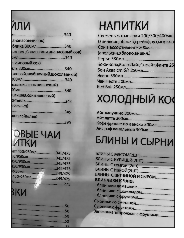

In [48]:
imgE_cl = cv2.imread(r'img/IMG_2747.JPG',0)
imgE = cv2.cvtColor(imgE_cl, cv2.COLOR_GRAY2RGB)
imgE = cv2.fastNlMeansDenoising(imgE,None,10,7,21)
print_img(imgE)

In [49]:
%%time
imgE_obj = imageToObject_simple(imgE, DOCUMENT_LANGUAGE)
print(len(imgE_obj))

187
CPU times: user 1.43 s, sys: 37.8 ms, total: 1.46 s
Wall time: 4.91 s


> re.sub('[^A-Za-z0-9А-Яа-я]', '',) -  применяем на оба объекта, по всем словам, потом сравнение по расстоянию
- Цикл по всем словам нового (если не нулевые) - запись разницы координат совпавших
- Выявление средних по top и по left - обрезка картинки
- Полное определение
- Добавление к старым (увеличив их координаты на средние значения)
- Перевалидация всех строк - по перекрытию по TOP, определение Insert текста
- Сортировка строк

In [53]:
def getMeanOffsets(json_py_obj, imgE_obj, alpha=0.2, printer=0):
    mean_diff_left = 0
    mean_diff_top = 0
    mean_diff_height = 0
    mean_diff_width = 0
    mean_capacity = []
    # [
    #   [ left,   right    ],
    #   [ down,   up       ],
    #   [ upsize, downsize ]
    # ]
    for ieo in range(len(imgE_obj)):
        if(len(imgE_obj[ieo]['text'])>2):
            nword = re.sub('[^А-Яа-я0-9A-Za-z]', '', imgE_obj[ieo]['text'].lower(), re.UNICODE)
            if(len(nword)>2):
                for ir in range(len(json_py_obj)):
                    for irw in range(len(json_py_obj[ir]['elems'])):
                        cword = re.sub('[^А-Яа-я0-9A-Za-z]', '', json_py_obj[ir]['elems'][irw]['text'].lower(), re.UNICODE)
                        if(len(cword)>2):
                            leven_num = levenshtein(nword,cword)
                            if(leven_num<1):
                                capacity, diff_left, diff_top, diff_height, diff_width = detectCapacityAndDiff(imgE_obj[ieo],json_py_obj[ir]['elems'][irw])
                                mean_diff_left = alpha * diff_left + (1 - alpha) * mean_diff_left
                                mean_diff_top = alpha * diff_top + (1 - alpha) * mean_diff_top
                                mean_diff_height = alpha * diff_height + (1 - alpha) * mean_diff_height
                                mean_diff_width = alpha * diff_width + (1 - alpha) * mean_diff_width
                                mean_capacity.append(capacity)
                                if(printer>1 and printer<3):
                                    print(leven_num)
                                    print(imgE_obj[ieo]['text']+'\n'+json_py_obj[ir]['elems'][irw]['text'])
                                    print(capacity)
    # вероятностная частота - сколько раз встречается на всего
    cap_all = [[0,0],[0,0],[0,0]]
    for im in range(len(mean_capacity)):
        if(mean_capacity[im][0][0]==0 and mean_capacity[im][0][1]==1):
            cap_all[0][1] +=1
        elif(mean_capacity[im][0][0]==1 and mean_capacity[im][0][1]==0):
            cap_all[0][0] +=1
        if(mean_capacity[im][1][0]==0 and mean_capacity[im][1][1]==1):
            cap_all[1][1] +=1
        elif(mean_capacity[im][1][0]==1 and mean_capacity[im][1][1]==0):
            cap_all[1][0] +=1
        if(mean_capacity[im][2][0]==0 and mean_capacity[im][2][1]==1):
            cap_all[2][1] +=1
        elif(mean_capacity[im][2][0]==1 and mean_capacity[im][2][1]==0):
            cap_all[2][0] +=1
    mcl = len(mean_capacity)
    cap_all = [[round(cap_all[0][0]/mcl,2),round(cap_all[0][1]/mcl,2)],
               [round(cap_all[1][0]/mcl,2),round(cap_all[1][1]/mcl,2)],
               [round(cap_all[2][0]/mcl,2),round(cap_all[2][1]/mcl,2)]]
    mean_diff_left = round(mean_diff_left)
    mean_diff_top = round(mean_diff_top)
    mean_diff_height = round(mean_diff_height)
    mean_diff_width = round(mean_diff_width)
    if(printer>0):
        print('left:'+str(mean_diff_left)+
              ' top:'+str(mean_diff_top)+
              ' height:'+str(mean_diff_height)+
              ' width:'+str(mean_diff_width)+
             ' capacity:'+str(cap_all))
    return mean_diff_left, mean_diff_top, mean_diff_height, mean_diff_width, cap_all
                                
def detectCapacityAndDiff(obj1, obj2, alpha=0.2):
    diff_left = int(obj1["left"]) - int(obj2["left"])
    diff_top = int(obj1["top"]) - int(obj2["top"])
    diff_height = int(obj1["height"]) - int(obj2["height"])
    diff_width = int(obj1["width"]) - int(obj2["width"])
    capacity_h = [0,0]
    capacity_v = [0,0]
    capacity_s = [0,0]
    if(diff_left>0):
        #right
        capacity_h[0] = 1
    else:
        #left
        capacity_h[1] = 1
    if(diff_top>0):
        #down
        capacity_v[0] = 1
    else:
        #up
        capacity_v[1] = 1
    if(str(abs(round(diff_height)))==str(abs(round(diff_width)))):
        if(diff_height>0 and diff_width>0):
            #upsize
            capacity_s[0] = 1
        else:
            #downsize
            capacity_s[1] = 1
    return [capacity_h,capacity_v,capacity_s], abs(diff_left), abs(diff_top), abs(diff_height), abs(diff_width)

def getCropWith(img, mdl, mdt, mdh, mdw, cap):
    # mdl, mdt, mdh, mdw - абсолютные значения
    # cap - матрица-указатель движения
    height, width, channels = img.shape
    top_s = 0
    top_e = height
    left_s = 0
    left_e = width
    if(cap[0][0]>0 and cap[0][1]>0):
        if(cap[0][0]>cap[0][1]):
            left_e = width - mdl # берем левую часть
        elif(cap[0][0]<cap[0][1]):
            left_s = width - mdl # берем правую часть
    if(cap[1][0]>0 and cap[1][1]>0):
        if(cap[1][0]>cap[1][1]):
            top_e = height - mdt # берем верхнюю часть
        elif(cap[0][0]<cap[0][1]):
            top_s = height - mdt # берем нижнюю часть
            
    # здесь можно доделать с тем, чтобы картинка обрезалась по масштабу еще, 
    # но для этого нужны абсолютные значения и очень сильно повышается сложность алгоритма
    # Заметка: обрезать все , что внутри и брать, что вне, по 4 части
    
    valid_img = img[top_s:top_e, left_s:left_e]
    return valid_img

def paddingPrev(img_obj, mdl, mdt, mdh, mdw, cap):
    # row - 'height': '0', 'top': '0', 'left': '0'
    # row_cell = 'height': '0', 'top': '0', 'left': '0', 'width':''
    left_p = 0
    top_p = 0
    if(cap[0][0]>0 and cap[0][1]>0):
        if(cap[0][0]>cap[0][1]):
            left_p = mdl # берем левую часть - расширяем слева - добавляем left для всех
        # elif(cap[0][0]<cap[0][1]): # берем правую часть - не нужно, просто добавление
            # left_s = width - mdl 
    if(cap[1][0]>0 and cap[1][1]>0):
        if(cap[1][0]>cap[1][1]):
            top_p = mdt # берем верхнюю часть - расширяем сверху - добавляем TOP для всех
        # elif(cap[0][0]<cap[0][1]):
            # top_s = height - mdt # берем нижнюю часть - не нужно, просто добавление
    for ir in range(len(img_obj)):
        img_obj[ir]['top'] = str(int(img_obj[ir]['top'])+top_p)
        img_obj[ir]['left'] = str(int(img_obj[ir]['left'])+left_p)
        for irw in range(len(img_obj[ir]['elems'])):
            img_obj[ir]['elems'][irw]['top'] = str(int(img_obj[ir]['elems'][irw]['top'])+top_p)
            img_obj[ir]['elems'][irw]['left'] = str(int(img_obj[ir]['elems'][irw]['left'])+left_p)
    return img_obj

def addingNew(img_obj, imgE_obj, cap, top_diff=0.4, printer=0):
    # Тут логика такая же, как при склейке строк в старом
    # Единственное исключение - мы не добавляем в конец строку, а ставим элементы новой сначала или сконца
    iobjs_len = len(imgE_obj)
    for i in range(iobjs_len): 
        if(printer==1):
            print(str(i)+' of '+str(len(img_obj)))
        t2 = int(imgE_obj[i]["top"])
        h2 = int(imgE_obj[i]["height"])
        if(printer==1):
            print(img_obj[i]["height"]+':'+str(t2))
        if (h2>0):
            j = 0
            new_flg = 1
            while j < len(img_obj):
                t1 = int(img_obj[j]["top"])
                h1 = int(img_obj[j]["height"])
                add_flg = 0
                if(h1>0):
                    # История про перекрытия
                    if(printer==1):
                        print('-   '+str(t1)+' < '+str(t2+h2)+' && '+str(t1+h1)+' > '+str(t2+h2))
                        print('--   '+str(t2)+' < '+str(t1+h1)+' && '+str(t2+h2)+' > '+str(t1+h1))
                    if (t1<t2+h2 and t1+h1>=t2+h2):
                        add_flg = 1
                    elif (t2<t1+h1 and t2+h2>=t1+h1):
                        add_flg = 1
                    if (add_flg==1):
                        minim_h = h2
                        if(h1<h2): 
                            minim_h = h1
                        diff_sq = 0
                        if ((t1+h1)>(t2+h2)):
                            diff_sq = h1 - (t1+h1-t2-h2)
                        else:
                            diff_sq = h2 - (t2+h2-t1-h1)
                        percent_diff = abs(diff_sq/minim_h);
                        if(printer==1):
                            print(percent_diff)

                        if (percent_diff>top_diff): # если перекрывает больше, чем на 40% (top_diff) меньшего, то добавляем
                            # append или prepend?
                            # Добавляем слова!
                            if(cap[0][0]>0 and cap[0][1]>0):
                                if(cap[0][0]>cap[0][1]):
                                    # берем левую часть - расширяем слева - добавляем left для всех
                                    img_obj[j]["elems"] = imgE_obj[i]["elems"]+img_obj[j]["elems"]
                                    if(printer==1):
                                        print('prepend')
                                elif(cap[0][0]<cap[0][1]):
                                    img_obj[j]["elems"] = img_obj[j]["elems"]+imgE_obj[i]["elems"]
                                    if(printer==1):
                                        print('append')
                            new_flg = 0
                            if(h2>h1):
                                img_obj[j]["height"] = str(h2)
                            j = len(img_obj)

                    # История про близость строк
                    # Для учета сильно разряженных документов
                    # Реализация на текущий момент отложена

                j = j+1
            if (new_flg==1):
                # append или prepend?
                # Добавляем строку!
                if(cap[1][0]>0 and cap[1][1]>0):
                    if(cap[1][0]>cap[1][1]):
                        # берем верхнюю часть - расширяем сверху - добавляем TOP для всех -  добавляем сверху
                        img_obj.insert(0, imgE_obj[i])
                        if(printer==1):
                            print('   new row prepend ')
                    elif(cap[0][0]<cap[0][1]):
                        img_obj.append(imgE_obj[i])
                        if(printer==1):
                            print('   new row append ')
                
    return img_obj

> json_py_obj - объект старой картинки

In [56]:
mdl, mdt, mdh, mdw, cap = getMeanOffsets(json_py_obj, imgE_obj,1.55,1)

left:1272 top:519 height:14 width:1029 capacity:[[0.93, 0.07], [0.8, 0.2], [0.0, 0.0]]


>**Обрезаем Картинку на основе полученных веротяностей и среднего экспоненциального смещения**

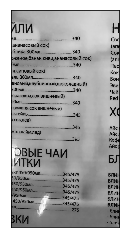

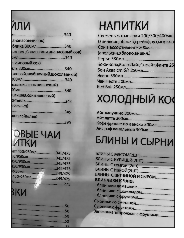

In [57]:
imgE_valid = getCropWith(imgE, mdl, mdt, mdh, mdw, cap)
print_img(imgE_valid)
print_img(imgE)

> **Производим распознование текста на выделенной картинке с довалидацией слов**

In [58]:
%%time
new_docE = imageToObject(imgE_valid, DOCUMENT_LANGUAGE, ru_lm, en_lm, 0)
new_docE_json = json.dumps(new_docE)
print(len(new_docE_json))

12114
CPU times: user 1.54 s, sys: 484 ms, total: 2.02 s
Wall time: 28.1 s


> Отображаем полученное

In [59]:
docConfiger(new_docE_json,'md','','display')

<br><h1>ИЛИ</h1>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Н** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0...... OOOOOOOOOO&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;С&nbsp;ве;&nbsp;&nbsp;&nbsp;&nbsp;<br>„ананасовый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сок)&nbsp;&nbsp;&nbsp;&nbsp;(апе&nbsp;&nbsp;&nbsp;&nbsp;<br>ублика&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...—...“.ЦООЦООСОООО.“ ......&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Сок&nbsp;&nbsp;&nbsp;&nbsp;<br>оженое‚банан&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;киви,ананасовый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сок)&nbsp;&nbsp;&nbsp;&nbsp;(а&nbsp;&nbsp;пе&nbsp;&nbsp;&nbsp;<br>№№…………….…340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Пер|&nbsp;&nbsp;&nbsp;&nbsp;<br>льсиновый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сок)&nbsp;&nbsp;&nbsp;&nbsp;Кока&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>ель&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;300мл..…..…..….. .....340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Бон&nbsp;&nbsp;&nbsp;&nbsp;<br>пановый‚клу6ничный‚шоколадный)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3314

a

C&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>ЗООмл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.5.»o..ouom.0‘&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Чай&nbsp;&nbsp;&nbsp;&nbsp;<br>18,KIOKBa,COK&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;вишневый)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кесі&nbsp;&nbsp;&nbsp;&nbsp;<br>ООмп&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>Н,ВИШНЯ,СОК&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ВИШНЕВЫ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;й)&nbsp;&nbsp;Х(&nbsp;&nbsp;октейпь&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.u-ocso.“ .....&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>й&nbsp;&nbsp;comen)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;о .. .“ ..и'цооспооео ..

....’..…345&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;АЙС&nbsp;&nbsp;&nbsp;&nbsp;<br>иятадаймлед)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;<br>1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;„……„395&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кофе&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;<br>

> **Преобразовыаем изначальный документ (смещение) и соединяем 2 документа по строчно**

In [60]:
%%time
# преобразование док-а изначального
# Запись новых строк в преобразованный
json_py_obj_evo = json_py_obj
json_py_obj_evo_o = paddingPrev(json_py_obj, mdl, mdt, mdh, mdw, cap)
json_py_obj_evo = addingNew(json_py_obj_evo_o, new_docE, cap, 0.4, 0)

CPU times: user 792 µs, sys: 128 µs, total: 920 µs
Wall time: 926 µs


In [64]:
%%time
json_py_obj_evo_json = ''
json_py_obj_evo_json = json.dumps(json_py_obj_evo_o)
docConfiger(json_py_obj_evo_json,'md','','display')
docConfiger(json_py_obj_evo_json,'html','save','display')

№№…………….…340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Пер|&nbsp;&nbsp;&nbsp;&nbsp;<br>ублика&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...—...“.ЦООЦООСОООО.“ ......&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Сок&nbsp;&nbsp;&nbsp;&nbsp;<br>„ананасовый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сок)&nbsp;&nbsp;&nbsp;&nbsp;(апе&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0...... OOOOOOOOOO&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;С&nbsp;ве;&nbsp;&nbsp;&nbsp;&nbsp;<br><h1>ИЛИ</h1>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Н** <br><br>оженое‚банан&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;киви,ананасовый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сок)&nbsp;&nbsp;&nbsp;&nbsp;(а&nbsp;&nbsp;пе&nbsp;&nbsp;&nbsp; **НАПИТКИ** <br>льсиновый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сок)&nbsp;&nbsp;&nbsp;&nbsp;Кока&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.340&nbsp;&nbsp;&nbsp;&nbsp;CaemesblmaTble&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;СОКИ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;200/300/400мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;260/ 290/365&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>ель&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;300мл..…..…..….. .....340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Бон&nbsp;&nbsp;&nbsp;&nbsp;(апельсин,яблоко‚грейпфрут,морковь‚сельдерей)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>пановый‚клу6ничный‚шоколадный)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3314

a

C&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;„340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Сок&nbsp;&nbsp;&nbsp;&nbsp;в&nbsp;&nbsp;accopmme HTe&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;200мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;130&nbsp;&nbsp;&nbsp;&nbsp;<br>ЗООмл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.5.»o..ouom.0‘&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Чай&nbsp;&nbsp;&nbsp;&nbsp;эвый&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;СОК)&nbsp;&nbsp;&nbsp;&nbsp;(апельсин,яблоко‚вишня‚)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>18,KIOKBa,COK&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;вишневый)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кесі&nbsp;&nbsp;&nbsp;&nbsp;„340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hepbe&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ЗЗОмл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;195&nbsp;&nbsp;&nbsp;&nbsp;<br>ООмп&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кока—Кола‚Кола-Лайт‚Спрайт,Фа нта&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;250мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;35&nbsp;&nbsp;&nbsp;<br>Н,ВИШНЯ,СОК&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ВИШНЕВЫ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;й)&nbsp;&nbsp;Х(&nbsp;&nbsp;октейпь&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.u-ocso.“ .....&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;…340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Бон&nbsp;&nbsp;&nbsp;&nbsp;Аква&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;С/г,&nbsp;&nbsp;б/г&nbsp;&nbsp;&nbsp;оооооооооооооо&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;125&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;падный)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Baman&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ЗЗОмл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;185&nbsp;&nbsp;&nbsp;&nbsp;<br>й&nbsp;comen)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;„340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Чай&nbsp;&nbsp;&nbsp;&nbsp;Нести&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;500мп&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;135&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;о .. .“ ..и'цооспооео ..

....’..…345&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;АЙС&nbsp;&nbsp;&nbsp;&nbsp;Веб&nbsp;&nbsp;&nbsp;&nbsp;Bull&nbsp;&nbsp;&nbsp;&nbsp;250мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;185&nbsp;&nbsp;&nbsp;&nbsp;<br>иятадаймлед)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;‚...340&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;„……„395&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кофе&nbsp;&nbsp;&nbsp;&nbsp;холодный&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _КОФЕ_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...345&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;капучино&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ЗООмл..&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2&nbsp;79&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;латте&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;300мл..&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;279&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.…395&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Кофе&nbsp;&nbsp;&nbsp;&nbsp;c|>panne&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;по—венски&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;300мл&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;......ОСООООООООО .....&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;79&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Айс&nbsp;&nbsp;&nbsp;&nbsp;раф&nbsp;&nbsp;&nbsp;ванильный&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;БЛИНЫ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;И&nbsp;&nbsp;СЫРНИКИ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>

CPU times: user 117 ms, sys: 25.5 ms, total: 143 ms
Wall time: 141 ms


>К сожалению, видно несовершенство алгоритма по склейке документов - он требует доработки в плане определения и добавления строк в документ.

# Заключение

В данной работе была произведена попытка создания "боевого" алгоритма для реального распознавания текста различных документов с последующей (отложенной) записью в файл. Сканирование удалось частично реализовать и полученные результаты, при прохождении ряда доработок, возможно будет портировать на мобильные платформы для предположительного использования.<br>
Дальнейшим развитием идеи видиться создание собственного алгоритма распознавания текста на основе распознавания векторов линий и доработка самого алгоритма в целом - как в части распознавания "главного" документа, так и довалидационных документов. Также нужно более детальное исследование некоторых параметров на предмет поведения общей модели при их изменении. <br>
Отдельно хотелось бы заметить, что в данном случае снятие метрик качества крайне затруднительно.

## Тест мультиязычности

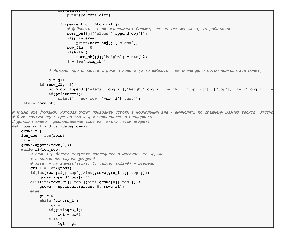

In [28]:
img_clm = cv2.imread(r'test_multi2.png',0)
imgm = cv2.cvtColor(img_clm, cv2.COLOR_GRAY2RGB)
imgm_demoise = cv2.fastNlMeansDenoising(imgm,None,10,7,21)
print_img(imgm_demoise)
imgm=imgm_demoise

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **print(percent_diff)** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if&nbsp;&nbsp;&nbsp; **(percent_diff>top_diff):** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Добавить&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ec1m&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;перекрывает&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **больше,** HEM&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ha&nbsp;&nbsp;&nbsp;&nbsp;40%&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;МЕНЬШЕГО,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To&nbsp;&nbsp;&nbsp;&nbsp; **добавляем** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **norm_obj[j]["elems"].append(obj[i])** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _if(printer==1):_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **print(norm_obj[j]["elems"])** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _newiflg_ O&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _if(h2>h1):_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **norm_obj[j]["height"]** str(h2)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _j_  **len(normiobj )** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;7f&nbsp;&nbsp;История&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;npo&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;близость&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;строки&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;M&nbsp;&nbsp;HOBOI'O&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(a&nbsp;&nbsp;&nbsp;T0&nbsp;&nbsp;&nbsp;&nbsp;выбросы&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;He&nbsp;&nbsp;&nbsp;&nbsp;O‘leHb&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A0&nbsp;&nbsp;&nbsp;&nbsp;M&nbsp;&nbsp;I70TOM&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ПРИГОДИТЬ СЯ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;може т )&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _j_  _j+1_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if&nbsp;&nbsp;&nbsp; _(newiflg==1) :_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **norm_obj.append({"elems":[obj[i]],"height":obj[i]["height"],"top":obj[i]["top"],**  _"left":obj[i]["le_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _if(printer==1):_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _print(‘_ new&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;row:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _'+obj[i]['text'])_ <br>&nbsp;&nbsp;&nbsp;&nbsp;return&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **norm_obj** <br>&nbsp;&nbsp;Нужна&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ewe&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h2>Функция,</h2>К оторая&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;будет&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ПРИБОДИТЬ&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;строки&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B&nbsp;&nbsp;нормальный&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BMA&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Bbllmcmvrb&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n0&nbsp;&nbsp;&nbsp;&nbsp;среднему&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;размер&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;тескта,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 ТСТУПА&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;ﬂmoc&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;copmposKy&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;сторк&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;no&nbsp;&nbsp;&nbsp;&nbsp;top&nbsp;&nbsp;&nbsp;&nbsp;,a/m&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;HeOBe‘IecKOI'O&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;рендеринга&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;Дополнительно&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,qoonpegeeHMe&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;C1703&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;M3&nbsp;&nbsp;&nbsp;&nbsp;TeKCTa&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;( если&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **_выйд е т )_**<br>def&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **rows_sort_and_validate(rows):** <br>&nbsp;&nbsp;&nbsp;&nbsp;grows&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp; _lenidoc_ len(rows)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;ri&nbsp;&nbsp;&nbsp;1&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;grows.append(rows[0]);&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;while&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **ri<len_doc:** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ec1m&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;top&nbsp;&nbsp;&nbsp;&nbsp;больше&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ТЕКУЩЕ Г 0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;nocnegHe I'O&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B&nbsp;&nbsp;массиве,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;T0&nbsp;&nbsp;&nbsp;&nbsp;append&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B&nbsp;&nbsp;противном&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;случае&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;prepend&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;arra&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _np. insert (array,_ 0,&nbsp;&nbsp;value,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _axis=0)_ prepend&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _grs_l_ len(grows)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if(int(rows[ri]['top‘])>int(grows[grs_l—1][‘top'])):** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _grows.append(rows[ri])_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _elif(int(rows[ri][‘top'])<int(grows[0][‘top‘])):_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;grows&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _np.insert(grows,_ 0,&nbsp;&nbsp; _rows[ri])_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;else:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _gi_ 0&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;while&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **(gi<grsil) :** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _lgi_ 0&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if ( gi+1<grsl) :** <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _lgi_  _gi+1_ <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;else&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _lgi_  _gi_ <br>

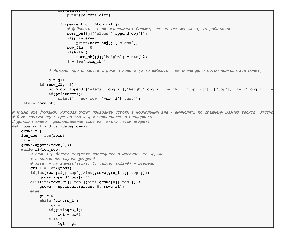

CPU times: user 1.87 s, sys: 1.09 s, total: 2.96 s
Wall time: 1min 7s


In [29]:
%%time
DOCUMENT_LANGUAGE = cropDetectLanguage(imgm,10,3,0)
# print(DOCUMENT_LANGUAGE)
json_py_objm = imageToObject(imgm, DOCUMENT_LANGUAGE, ru_lm, en_lm,0)
json_py_strm = json.dumps(json_py_objm)
# print(len(json_py_str))
docConfiger(json_py_strm,'html','save','display')
docConfiger(json_py_strm,'md','','display')
print_img(imgm)